<a href="https://colab.research.google.com/github/euguroglu/Machine-Learning-Projects/blob/master/Pytorch_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import wandb

In [2]:
wandb.init(project="CIFAR10-Pytorch")

wandb: Currently logged in as: enesuguroglu (use `wandb login --relogin` to force relogin)


## Data Loading

In [3]:
transform = transforms.ToTensor()

In [4]:
train_Data = datasets.CIFAR10(root='C:/Users/PC/Documents/Jupyter/Pytorch',train=True,download=True,transform=transform)

Files already downloaded and verified


In [5]:
test_Data = datasets.CIFAR10(root='C:/Users/PC/Documents/Jupyter/Pytorch',train=False,download=True,transform=transform)

Files already downloaded and verified


In [6]:
train_Data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:/Users/PC/Documents/Jupyter/Pytorch
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_Data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:/Users/PC/Documents/Jupyter/Pytorch
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
torch.manual_seed(101)

In [9]:
train_loader = DataLoader(train_Data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_Data,batch_size=10,shuffle=False)

In [10]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [11]:
for images,labels in train_loader:
  break

In [12]:
labels

tensor([9, 5, 2, 3, 0, 5, 9, 5, 1, 6])

## Data visualization

Label: [    9     5     2     3     0     5     9     5     1     6]
Class:  truck   dog  bird   cat plane   dog truck   dog   car  frog


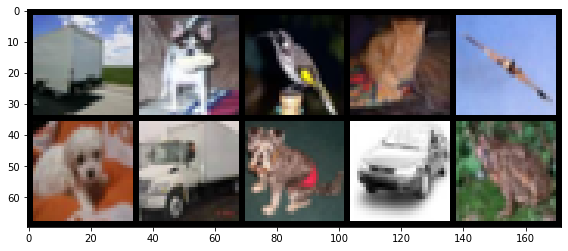

In [13]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))

print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

## Convolutional Neural Network

In [14]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,1) #Mnist data set i used (1,6,5,1) 1 was because mnish data is grayscale which is 1 channel but here in this data set we have rgb color which has 3 channel
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(6*6*16,120) # 6*6 comes from --> 1 conv -->32 to 28 --> 1 pooling 28 to 14 --> 1 conv 14 to 12 --> 1 pooling 12 to 6 which is 6 
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    X = X.view(-1,6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    x = self.fc3(X)
    return F.log_softmax(X,dim=1) 

In [15]:
torch.manual_seed(101)

In [16]:
model = ConvolutionalNetwork()

## Checking model parameters

In [17]:
for param in model.parameters():
  print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


## Defining cost function and optimization

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
config=wandb.config
config.lr = 0.001

## Training

In [20]:
import time
start_time = time.time()

#Variables (Trackers)
epochs = 15
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []

#For loops epochs
wandb.watch(model,criterion,log="all")
for i in range(epochs):

  trn_corr = 0
  tst_corr = 0


#Train
  
  for b,(X_train,y_train) in enumerate(train_loader):
    b = b + 1

    y_pred = model(X_train) #not flattening (conv)
    loss = criterion(y_pred,y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batch_corr = (predicted == y_train).sum() # True:1 / False:0 sum
    trn_corr = trn_corr + batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b%1000 == 0):
      print('Epoch: {} Batch: {} Loss: {} Accuracy: {}'.format(i,b,loss.item(),(trn_corr//(b/10))))
      accuracy.append((trn_corr//(b/10)))
      wandb.log({'loss':loss.item(),'Epoch':i,'accuracy':trn_corr//(b/10)})
  train_losses.append(loss)
  train_correct.append(trn_corr)


#Test

  with torch.no_grad():
    for b, (X_test,y_test) in enumerate(test_loader):

      y_val = model(X_test)

      predicted = torch.max(y_val.data,1)[1]
      tst_corr = (predicted == y_test).sum()
      
  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print('Training took {}  minutes'.format(total/60))

Epoch: 0 Batch: 1000 Loss: 3.1816694736480713 Accuracy: 17.0
Epoch: 0 Batch: 2000 Loss: 3.305520534515381 Accuracy: 23.0
Epoch: 0 Batch: 3000 Loss: 2.3584117889404297 Accuracy: 26.0
Epoch: 0 Batch: 4000 Loss: 3.0346999168395996 Accuracy: 29.0
Epoch: 0 Batch: 5000 Loss: 3.1530849933624268 Accuracy: 30.0
Epoch: 1 Batch: 1000 Loss: 1.487277626991272 Accuracy: 39.0
Epoch: 1 Batch: 2000 Loss: 3.2962727546691895 Accuracy: 39.0
Epoch: 1 Batch: 3000 Loss: 3.37324595451355 Accuracy: 39.0
Epoch: 1 Batch: 4000 Loss: 2.2604241371154785 Accuracy: 39.0
Epoch: 1 Batch: 5000 Loss: 2.104200601577759 Accuracy: 40.0
Epoch: 2 Batch: 1000 Loss: 2.2329726219177246 Accuracy: 43.0
Epoch: 2 Batch: 2000 Loss: 2.405635356903076 Accuracy: 43.0
Epoch: 2 Batch: 3000 Loss: 3.1837503910064697 Accuracy: 43.0
Epoch: 2 Batch: 4000 Loss: 1.7773593664169312 Accuracy: 43.0
Epoch: 2 Batch: 5000 Loss: 2.668412923812866 Accuracy: 43.0
Epoch: 3 Batch: 1000 Loss: 2.0453686714172363 Accuracy: 44.0
Epoch: 3 Batch: 2000 Loss: 2.28

## Saving model

In [ ]:
torch.save(model.state_dict(),'myCıfarmodel.pt')

## Results

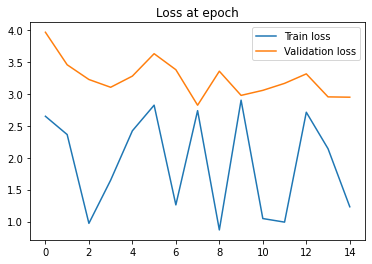

In [ ]:
plt.plot(train_losses,label='Train loss')
plt.plot(test_losses,label='Validation loss')
plt.title('Loss at epoch')
plt.legend()
plt.show()

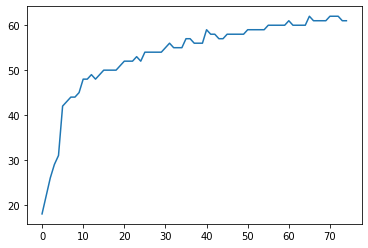

In [ ]:
plt.plot(range(75),accuracy) # Accuracy per batch

In [ ]:
print(test_correct)

[tensor(2), tensor(2), tensor(2), tensor(3), tensor(2), tensor(3), tensor(2), tensor(4), tensor(3), tensor(3), tensor(3), tensor(3), tensor(2), tensor(3), tensor(3)]


## Validation on test set and confusion matrix

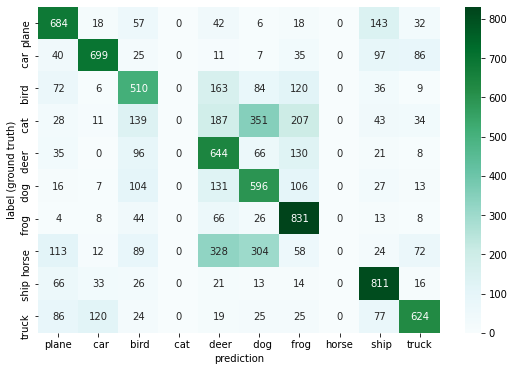

In [ ]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_Data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();